In [2]:
import os
import tarfile
import numpy as np
import pandas as pd
from six.moves import urllib

# Loading Data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"    
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Extract data from the specified url link.

    Parameters
    ----------
    housing_url : str
        The url to the source data.

    housing_path : str
        The path to store the extracted data.
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """
    Load the data from extracted path as dataframe.

    Parameters
    ----------
    housing_path : str
        The path to the extracted data.

    Returns
    -------
    pandas.DataFrame
        The loaded data as a pandas DataFrame.

    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


In [ ]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

/tmp/ipykernel_116345/1335753976.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [104]:
housing = load_housing_data(HOUSING_PATH)

# EDA

In [64]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

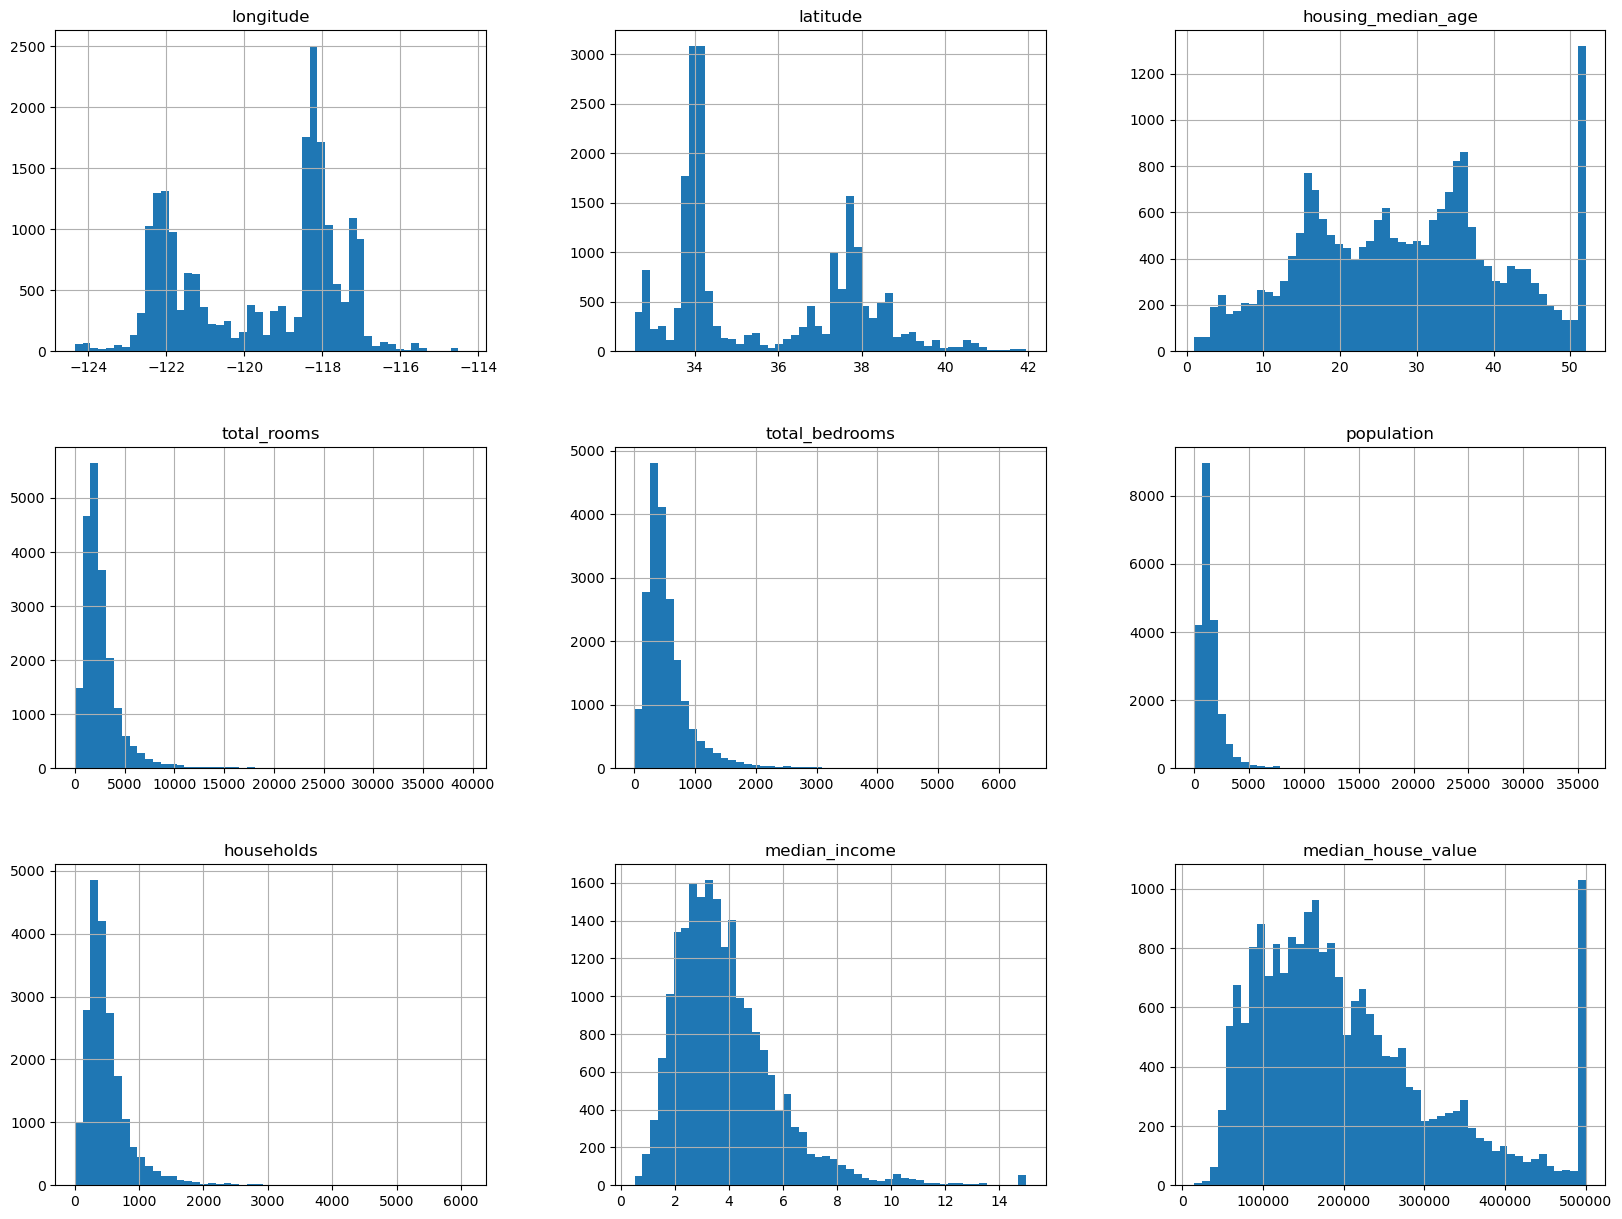

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

# Train-Test Split and Data Manipulation

In [105]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(housing):
    """
    Split the data into train and test sets using stratified sampling.

    Parameters
    ----------
    housing : pandas.DataFrame
        The input data as a pandas Dataframe.

    Returns
    -------
    strat_train_set : pandas.DataFrame
        The train dataset as a pandas DataFrame.

    strat_test_set : pandas.DataFrame
        The test dataset as a pandas DataFrame.

    """
    housing["income_cat"] = pd.cut(
        housing["median_income"],
        bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
        labels=[1, 2, 3, 4, 5],
    )

    print("Histogram of housing income category attribute")
    housing["income_cat"].hist()

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]
    return strat_train_set, strat_test_set


Histogram of housing income category attribute


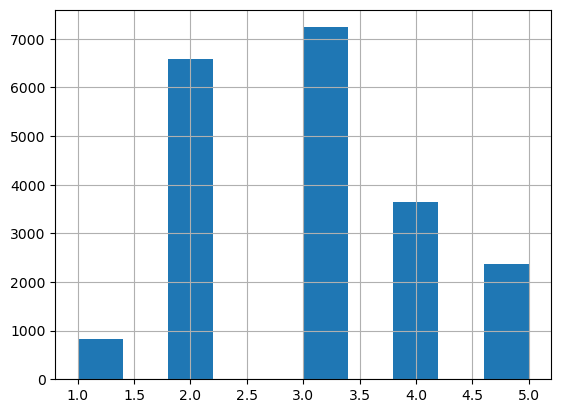

In [106]:
strat_train_set, strat_test_set = stratified_split(housing)

In [107]:
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))

print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


<Axes: xlabel='longitude', ylabel='latitude'>

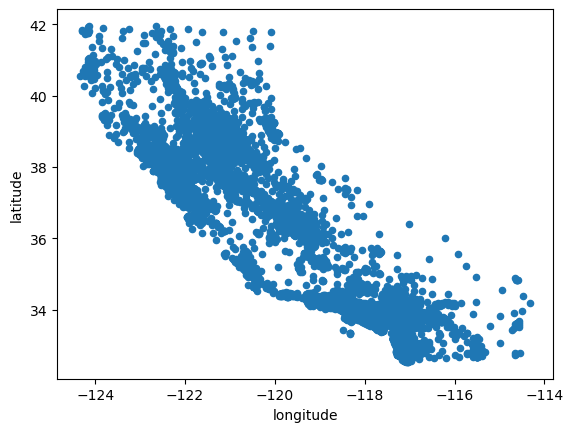

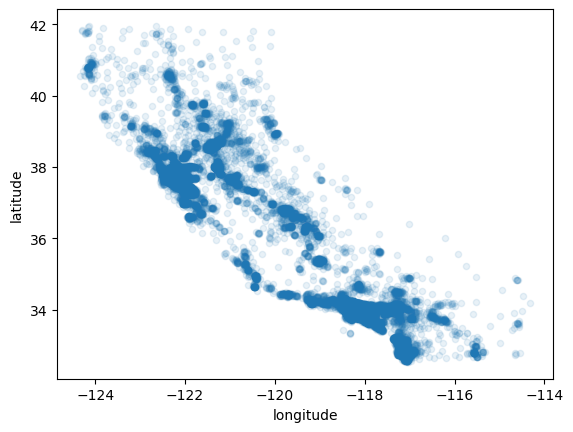

In [108]:
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

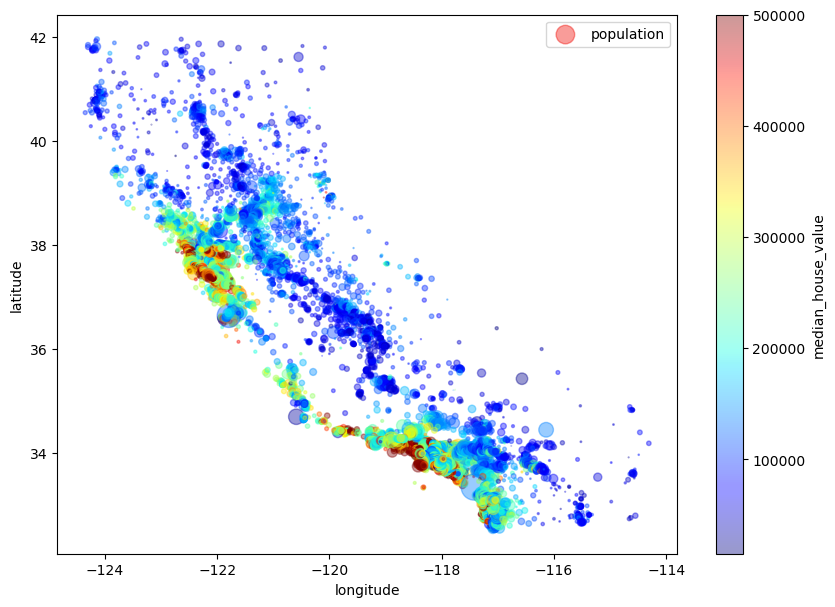

In [109]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [110]:
def clean_strat_data(strat_train_set, strat_test_set):
    """
    Cleans the stratified training and test datasets.

    Parameters
    ----------
    strat_train_set : pandas.DataFrame
        The stratified training dataset.

    strat_test_set : pandas.DataFrame
        The stratified test dataset.

    Returns
    -------
    pandas.DataFrame
        The cleaned housing dataset, excluding 'income_cat'.

    pandas.Series
        The labels of the training dataset.

    pandas.DataFrame
        The numeric features of the training dataset.
    """
    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)

    housing = strat_train_set.copy()

    corr_matrix = housing.corr(numeric_only=True)
    print(corr_matrix["median_house_value"].sort_values(ascending=False))
    return housing, strat_train_set, strat_test_set

In [111]:
housing, strat_train_set, strat_test_set = clean_strat_data(strat_train_set, strat_test_set)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

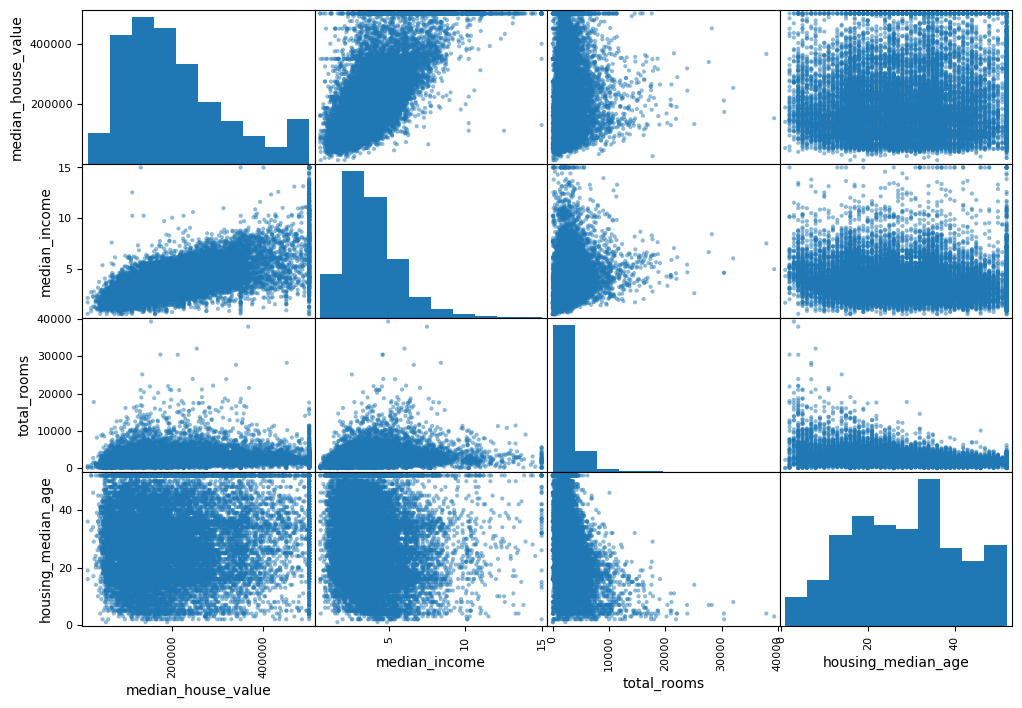

In [112]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

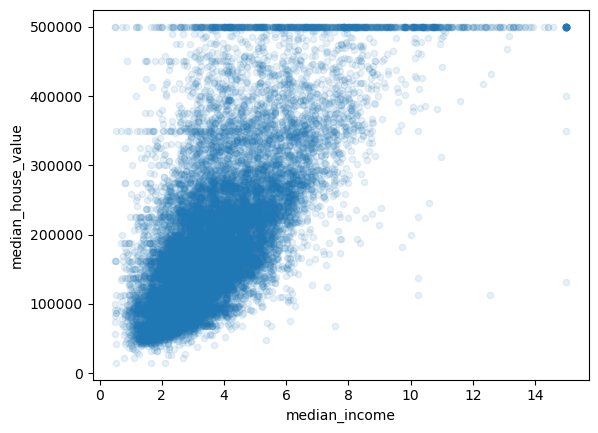

In [113]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

In [114]:
def add_features(housing):
    """
    Create and add the columns - rooms_per_household, bedrooms_per_room and
    population_per_household to the datframe.

    Parameters
    ----------
    housing : pandas.DataFrame
        The input data containing the housing dataset.

    Returns
    -------
    pandas.DataFrame
        The housing dataset with three new columns.

    """
    housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
    housing["population_per_household"] = housing["population"] / housing["households"]
    return housing


def data_manipulation(strat_set):
    """
    Splits the stratified dataset into features and labels.

    Parameters
    ----------
    strat_set : pandas.DataFrame
        The input dataset containing features and labels.

    Returns
    -------
    pandas.DataFrame
        The features as a pandas DataFrame.

    pandas.Series
        The labels as a pandas Series.

    pandas.DataFrame
        The numeric features as a pandas DataFrame.
    """
    housing = strat_set.drop("median_house_value", axis=1)
    housing_labels = strat_set["median_house_value"].copy()
    housing_num = housing.drop("ocean_proximity", axis=1)
    return housing, housing_labels, housing_num

In [115]:
housing = add_features(housing)

corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


In [116]:
housing, housing_labels, housing_num = data_manipulation(strat_train_set)

In [117]:
from sklearn.impute import SimpleImputer

def prepare_dataframe(X, housing_num, housing):
    """
    Prepares the feature dataframe by adding new features and converting categorical
    features to one-hot encoding.

    Parameters
    ----------
    X : numpy.ndarray
        The transformed numeric data after preprocessing.

    housing_num : pandas.DataFrame
        The numeric features of the housing dataset.

    housing : pandas.DataFrame
        The housing dataset.

    Returns
    -------
    pandas.DataFrame
        The prepared feature dataframe.
    """
    housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)
    housing_tr = add_features(housing_tr)
    housing_cat = housing[["ocean_proximity"]]
    return housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

def prepare_train_data(imputer, housing, housing_num):
    """
    Prepares the training data by applying imputation and transforming the features.

    Parameters
    ----------
    imputer : sklearn.impute.SimpleImputer
        The imputer object used to handle missing values in the numeric data.

    housing : pandas.DataFrame
        The housing training dataset.

    housing_num : pandas.DataFrame
        The numeric features of the housing dataset.

    Returns
    -------
    pandas.DataFrame
        The prepared training dataset.
    """

    X = imputer.transform(housing_num)
    housing_prepared = prepare_dataframe(X, housing_num, housing)
    #housing_prepared = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
    return housing_prepared

In [118]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)
housing_prepared = prepare_train_data(imputer, housing, housing_num)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [119]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(5)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN

In [120]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(cat_encoder.categories_)
housing_cat_1hot

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [122]:
housing_prepared.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [123]:
#housing_prepared = housing_prepared.join(pd.get_dummies(housing_cat, drop_first=True))

In [124]:
X_test, y_test, X_test_num = data_manipulation(strat_test_set)
X_test_prepared = imputer.transform(X_test_num)
X_test_prepared = prepare_dataframe(X_test_prepared, X_test_num, X_test)

In [125]:
housing_prepared.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [126]:
X_test_prepared.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

# Model Training

### Linear Regression

In [129]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [132]:
housing_prepared.columns, X_test_prepared.columns

(Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
        'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
        'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
       dtype='object'),
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
        'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
        'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
       dtype='object'))

In [133]:
from sklearn.metrics import mean_squared_error

reg_predictions = lin_reg.predict(X_test_prepared)
reg_mse = mean_squared_error(y_test, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("MSE :", reg_mse)
print("RMSE :", reg_rmse)

MSE : 4477408708.672437
RMSE : 66913.44191320932


In [134]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores

array([71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082,
       66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334,
       66443.28836884, 70139.79923956])

### Decision Tree

In [135]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [136]:
tree_predictions = tree_reg.predict(X_test_prepared)
tree_mse = mean_squared_error(y_test, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
print("MSE :", tree_mse)
print("RMSE :", tree_rmse)

MSE : 4827195305.66279
RMSE : 69478.02030615718


In [137]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([72562.39690913, 71023.44196472, 68857.79659174, 73169.01371528,
       69209.37557084, 75754.63271323, 71164.99610531, 72995.82812881,
       68112.20577432, 71281.32632756])

### Random Forest

In [139]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [140]:
forest_predictions = forest_reg.predict(X_test_prepared)
forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("MSE :", forest_mse)
print("RMSE :", forest_rmse)

MSE : 2360509015.3807287
RMSE : 48585.06988140213


In [141]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
forest_rmse_scores

array([51710.60868535, 49240.01944956, 46930.0694474 , 52063.41047721,
       47558.82953674, 51900.38452352, 52375.35271213, 50111.7685515 ,
       48259.49840124, 54164.8165465 ])

### Grid Search in Random Forest

In [142]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

grid_forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(grid_forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [164]:
grid_forest_predictions = grid_search.predict(X_test_prepared)
grid_forest_mse = mean_squared_error(y_test, grid_forest_predictions)
grid_forest_rmse = np.sqrt(grid_forest_mse)
print("MSE :", grid_forest_mse)
print("RMSE :", grid_forest_rmse)

MSE : 2281723216.4861665
RMSE : 47767.38653606838


In [144]:
scores = cross_val_score(grid_search, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
grid_forest_rmse_scores = np.sqrt(-scores)
grid_forest_rmse_scores

array([51597.68862189, 48360.84124735, 47322.69604978, 51093.44029699,
       47288.49952024, 49853.98142312, 52130.35914107, 49116.92438884,
       48125.16674803, 53313.25010077])

In [145]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [146]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [79]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65074.863427288146 {'max_features': 2, 'n_estimators': 3}
55077.71738648645 {'max_features': 2, 'n_estimators': 10}
52247.66039044009 {'max_features': 2, 'n_estimators': 30}
60303.199107617416 {'max_features': 4, 'n_estimators': 3}
53060.00428207984 {'max_features': 4, 'n_estimators': 10}
50416.11388781913 {'max_features': 4, 'n_estimators': 30}
58990.52427356697 {'max_features': 6, 'n_estimators': 3}
52551.56004017556 {'max_features': 6, 'n_estimators': 10}
50007.073656478235 {'max_features': 6, 'n_estimators': 30}
58287.13090802111 {'max_features': 8, 'n_estimators': 3}
52009.6429010604 {'max_features': 8, 'n_estimators': 10}
50062.07321980283 {'max_features': 8, 'n_estimators': 30}
61243.05909589026 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53920.79040652484 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59715.1094771661 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52365.4097276703 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [150]:
feature_importances = grid_search.best_estimator_.feature_importances_

### Randomized Search

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
            "n_estimators": randint(low=1, high=200),
            "max_features": randint(low=1, high=8),
        }

rnd_search = RandomizedSearchCV(
            forest_reg,
            param_distributions=param_distribs,
            n_iter=10,
            cv=5,
            scoring="neg_mean_squared_error",
            random_state=42,
        )
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f54b0f54050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f54c6d6ecf0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [165]:
rnd_search_predictions = grid_search.predict(X_test_prepared)
rnd_search_mse = mean_squared_error(y_test, rnd_search_predictions)
rnd_search_rmse = np.sqrt(rnd_search_mse)
print("MSE :", rnd_search_mse)
print("RMSE :", rnd_search_rmse)

MSE : 2281723216.4861665
RMSE : 47767.38653606838


In [149]:
scores = cross_val_score(rnd_search, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rnd_search_rmse_scores = np.sqrt(-scores)
rnd_search_rmse_scores

array([50590.00416303, 47418.29646881, 45912.33323575, 50043.09965728,
       46939.49407977, 49818.22710121, 50632.23946467, 48061.21782309,
       47416.91976173, 52717.65936856])

In [151]:
rnd_search.best_params_

{'max_features': 5, 'n_estimators': 100}

In [152]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=5)

In [153]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49253.05538568853 {'max_features': 7, 'n_estimators': 180}
51284.334693334094 {'max_features': 5, 'n_estimators': 15}
50486.29945890118 {'max_features': 3, 'n_estimators': 72}
50711.31818670607 {'max_features': 5, 'n_estimators': 21}
49344.48350777451 {'max_features': 7, 'n_estimators': 122}
50716.90797300322 {'max_features': 3, 'n_estimators': 75}
50427.80311221008 {'max_features': 3, 'n_estimators': 88}
49215.60373423551 {'max_features': 5, 'n_estimators': 100}
50078.33795258714 {'max_features': 3, 'n_estimators': 150}
65182.03515506721 {'max_features': 5, 'n_estimators': 2}


In [155]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.81812235e-02, 7.58870569e-02, 4.43741506e-02, 1.92058867e-02,
       1.79394473e-02, 1.93108387e-02, 1.74272117e-02, 3.18840104e-01,
       6.52312680e-02, 8.32448429e-02, 1.06684337e-01, 1.45658854e-01,
       9.65981979e-05, 3.20022332e-03, 4.71795743e-03])

### SVM

#### Linear Kernel SVR

In [163]:
from sklearn.svm import SVR

lin_svr_models = []
for i in [0.1, 1, 10, 100]:
    linear_svr = SVR(kernel='linear', C=i)
    linear_svr.fit(housing_prepared, housing_labels)
    lin_svr_models.append(linear_svr)
    lin_svr_predictions = linear_svr.predict(X_test_prepared)
    lin_svr_mse = mean_squared_error(y_test, lin_svr_predictions)
    lin_svr_rmse = np.sqrt(lin_svr_mse)
    print("For C =", i)
    print("MSE :", lin_svr_mse)
    print("RMSE :", lin_svr_rmse)

For C = 0.1
MSE : 11161726241.139166
RMSE : 105649.07117972767
For C = 1
MSE : 8593209631.042753
RMSE : 92699.56650946515
For C = 10
MSE : 5131908823.127752
RMSE : 71637.34237901175
For C = 100
MSE : 4734351880.273621
RMSE : 68806.62671773425


#### RBF kernal SVR

In [173]:
rbf_svr_models = []

for i in [[10, 'scale'], [1, 'auto'], [1, 0.1], [10, 10]]:
    rbf_svr = SVR(kernel='rbf', C=i[0], gamma=i[1])
    rbf_svr.fit(housing_prepared, housing_labels)
    rbf_svr_models.append(rbf_svr)
    rbf_svr_predictions = rbf_svr.predict(X_test_prepared)
    rbf_svr_mse = mean_squared_error(y_test, rbf_svr_predictions)
    rbf_svr_rmse = np.sqrt(rbf_svr_mse)
    print("For C =", i[0], "and Gamma =", i[1])
    print("MSE :", rbf_svr_mse)
    print("RMSE :", rbf_svr_rmse)

For C = 10 and Gamma = scale
MSE : 13616759944.602997
RMSE : 116690.8734417692
For C = 1 and Gamma = auto
MSE : 13749138646.48841
RMSE : 117256.72111434981
For C = 1 and Gamma = 0.1
MSE : 13749138656.984613
RMSE : 117256.72115910718
For C = 10 and Gamma = 10
MSE : 13749170774.405514
RMSE : 117256.85811245973


## Pipeline for Data Transformation

In [226]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Custom transformer to convert new features.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        total_rooms_idx = 0
        total_bedrooms_idx = 1
        population_idx = 2
        households_idx = 3

        rooms_per_household = X[:, total_rooms_idx] / X[:, households_idx]
        bedrooms_per_room = X[:, total_bedrooms_idx] / X[:, total_rooms_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]

        transformed_data = np.column_stack([ X, rooms_per_household,
                                            bedrooms_per_room, population_per_household])
        feature_names = (['total_rooms', 'total_bedrooms', 'population', 'households', 
                        'rooms_per_household', 'bedrooms_per_room', 'population_per_household'])
        return pd.DataFrame(transformed_data, columns=feature_names)



numerical_cols = ['total_rooms', 'total_bedrooms', 'population', 'households']
categorical_cols = ['ocean_proximity']
other_cols = ['longitude', 'latitude', 'housing_median_age', 'median_income'] 

attr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('scaler', StandardScaler())
])

onehotenc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

impute_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', attr_pipeline, numerical_cols),
        ('cat', onehotenc_pipeline, categorical_cols),
        ('other', impute_pipeline, other_cols)
    ])

full_pipeline = Pipeline([('preprocessor', preprocessor)])

In [225]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

Histogram of housing income category attribute
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


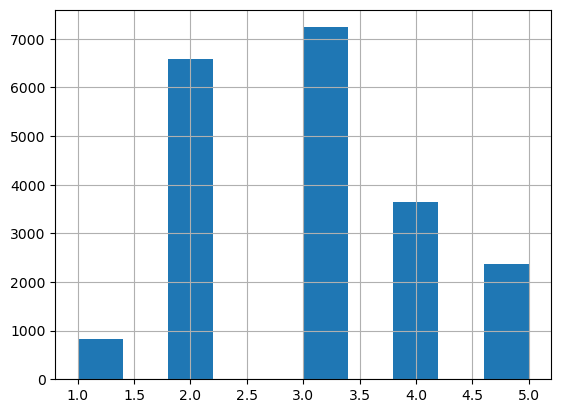

In [227]:
housing = load_housing_data(HOUSING_PATH)

strat_train_set, strat_test_set = stratified_split(housing)
housing, strat_train_set, strat_test_set = clean_strat_data(strat_train_set, strat_test_set)

X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"]
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

full_pipeline.fit(X_train)

X_train_transformed = full_pipeline.transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)


In [228]:
X_train.shape, X_train.head()

((16512, 9),
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
 12655    -121.46     38.52                29.0       3873.0           797.0   
 15502    -117.23     33.09                 7.0       5320.0           855.0   
 2908     -119.04     35.37                44.0       1618.0           310.0   
 14053    -117.13     32.75                24.0       1877.0           519.0   
 20496    -118.70     34.28                27.0       3536.0           646.0   
 
        population  households  median_income ocean_proximity  
 12655      2237.0       706.0         2.1736          INLAND  
 15502      2015.0       768.0         6.3373      NEAR OCEAN  
 2908        667.0       300.0         2.8750          INLAND  
 14053       898.0       483.0         2.2264      NEAR OCEAN  
 20496      1837.0       580.0         4.4964       <1H OCEAN  )

In [229]:
X_train_transformed.shape, X_train_transformed

((16512, 16),
 array([[ 0.58477745,  0.64037127,  0.73260236, ..., 38.52      ,
         29.        ,  2.1736    ],
        [ 1.26146668,  0.78156132,  0.53361152, ..., 33.09      ,
          7.        ,  6.3373    ],
        [-0.46977281, -0.54513828, -0.67467519, ..., 35.37      ,
         44.        ,  2.875     ],
        ...,
        [-0.89580177, -0.8956791 , -0.86201341, ..., 38.44      ,
         48.        ,  3.1797    ],
        [ 0.2490049 ,  0.11212574, -0.18974707, ..., 38.31      ,
         14.        ,  4.1964    ],
        [-0.72183605, -0.75935767, -0.71232211, ..., 39.97      ,
         27.        ,  3.1319    ]], shape=(16512, 16)))